#### Instala os módulos necessários

In [ ]:
%pip install lightgbm
%pip install numpy
%pip install matplotlib
%pip install pandas
%pip install scikit-learn
%pip install warnings
%pip install xgboost

#### Importa os módulos necessários

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import KNNImputer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

#### Ignora warnings que serão gerados

In [3]:
warnings.filterwarnings("ignore")

#### Análise exploratória, feature engineering, treinamento e avaliação do modelo

In [4]:
raw = pd.read_csv(r"_datasets/dataset.csv")

In [5]:
raw.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


A variável "total_bedrooms" apresenta 207 nulos, dessa forma, realizaremos a inputação dos dados utilizando a função [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) do SKLearn para preencher os valores ausentes. De modo geral, a função aplica a média (ou outra estatistica de sua preferência) dos "k" vizinhos mais próximos do dado faltante e atribui o resultado ele.

Entretanto, para isso, precisaremos converter a variável "ocean_proximity" para valores numéricos, visto que o KNNImputer não consegue lidar com textos. Para isso, assumiremos que quanto mais próximo o imóvel está em relação ao oceano, maior será o seu valor. Sendo assim, precisaremos descobrir quais são as categorias e a média de valor dos imóveis para cada uma delas.

In [7]:
raw.groupby(by="ocean_proximity")["median_house_value"].mean().sort_values(ascending=False)

ocean_proximity
ISLAND        380440.000000
NEAR BAY      259212.311790
NEAR OCEAN    249433.977427
<1H OCEAN     240084.285464
INLAND        124805.392001
Name: median_house_value, dtype: float64

Note que a variável "ocean_proximity" possui 5 categorias: ISLAND, ou ilha; NEAR BAY, ou próximo ao baia; NEAR OCEAN, ou próximo ao oceano; <1H OCEAN, ou menos de uma hora de distância do oceano; e, INLAND, ou interior. Neste caso, atribuiremos pesos (1.0, 0.8, 0.6, 0.4, 0.2) a cada categoria, priorizando aquelas em que o imóvel está mais próximo do oceano, visto que a nossa hipótese é que imóveis localizados mais próximos do oceano em média são mais valorizados.

In [8]:
raw["ocean_proximity"] = raw["ocean_proximity"].apply(lambda x: 1.0 if x == "ISLAND" else x)
raw["ocean_proximity"] = raw["ocean_proximity"].apply(lambda x: 0.8 if x == "NEAR BAY" else x)
raw["ocean_proximity"] = raw["ocean_proximity"].apply(lambda x: 0.6 if x == "NEAR OCEAN" else x)
raw["ocean_proximity"] = raw["ocean_proximity"].apply(lambda x: 0.4 if x == "<1H OCEAN" else x)
raw["ocean_proximity"] = raw["ocean_proximity"].apply(lambda x: 0.2 if x == "INLAND" else x)

In [9]:
raw.groupby(by="ocean_proximity")["median_house_value"].mean().sort_values(ascending=False)

ocean_proximity
1.0    380440.000000
0.8    259212.311790
0.6    249433.977427
0.4    240084.285464
0.2    124805.392001
Name: median_house_value, dtype: float64

Neste momento, o conjunto de dados possui apenas dados numéricos, ou seja, podemos aplicar a função KNNImputer para preencher os dados faltantes. Entretanto, precisamos definir qual o melhor valor para "k", portanto, iremos criar uma lista com valores de 2 a 6, e em seguida, testar cada um dos conjuntos de dados nos modelos que serão treinados.

In [10]:
k_values = [2, 3, 4, 5, 6]

specs = []

for k in k_values:
    # Reseta o dataframe "stage" para os dados do dataframe "raw"
    stage = raw.copy()

    # Armazena o nome das colunas do dataframe "stage" em uma lista
    cols_names = list(stage.columns)

    # Instancia o KNNImputer com "k" vizinhos para imputar os dados faltantes
    imputer = KNNImputer(n_neighbors=k)

    # Adiciona o dataframe "spec" com o resultado KNNImputer e renomeia colunas
    specs.append(pd.DataFrame(imputer.fit_transform(stage), columns=cols_names))

Sem dados faltantes, realizaremos o treinamento do [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html), que de maneira geral, faz o ensamble (ou combinação) de "n" árvores de regressão para gerar um modelo final, utilizando a função [RandomizedSearchCV](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.RandomizedSearchCV.html), que de modo geral, escolhe de maneira aleatória os hiperparâmetros a partir de uma lista pré-estabelecida e, por fim, apresenta o melhor resultado.

In [ ]:
rf_results = {
    "RMSE" : [],
    "R2" : [],
    "PARAMS" : []
}

rf_custom_parameters = {
    "n_estimators" : [100, 150, 200],
    "max_depth" : [None, 1, 2, 3, 4, 5],
    "min_samples_split" : [None, 1, 2, 3, 4, 5],
    "min_samples_leaf" : [None, 1, 2, 3, 4, 5]
}

for spec in specs:
    # Separa as variáveis entre preditoras "x" e predita "y" e converte para float32
    x = spec[["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "ocean_proximity"]].astype("float32")
    y = spec["median_house_value"].astype("float32")

    # Separa os dados entre conjuntos de treino e teste 
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

    # Instancia o RandomizedSearchCV com random_state 42
    rf = RandomForestRegressor(random_state=42)

    # Utiliza o RandomizedSearchCV para estimar os melhores parâmetros utilizados para treinar o modelo
    rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=rf_custom_parameters, cv=5, scoring="neg_mean_squared_error", verbose=True, n_jobs=-1)

    # Realiza o treinamento do modelo com dados de treino
    rf_random_search.fit(x_train, y_train)

    # Elege o melhor modelo utilizando a função best_estimator_
    rf_best_model = rf_random_search.best_estimator_

    # Realiza a predição com base no melhor modelo
    rf_y_pred = rf_best_model.predict(x_test)

    # Calcula as métricas de erro do modelo RMSE e R2
    rmse = np.sqrt(mean_squared_error(y_test, rf_y_pred))
    r2 = r2_score(y_test, rf_y_pred)

    # Adiciona o resultado do treinamento a lista de resultados
    rf_results.get("RMSE").append(round(rmse, 2))
    rf_results.get("R2").append(round(r2, 2))
    rf_results.get("PARAMS").append(rf_random_search.best_params_)

In [12]:
print("================================================== RESULTADOS ==================================================")
print(f"RMSE: {rf_results.get('RMSE')}")
print(f"R²: {rf_results.get('R2')}")
print(f"PARAMS: {rf_results.get('PARAMS')}")
print("================================================================================================================")

================================================== RESULTADOS ==================================================
RMSE: [48552.37, 48755.75, 67785.35, 48601.58, 67818.77]
R²: [0.82, 0.82, 0.65, 0.82, 0.65]
PARAMS: [{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}, {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': None}, {'n_estimators': 150, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 5}, {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': None}, {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 5}]


In [13]:
print("=================================================== VENCEDOR ===================================================")
print(f"RMSE: {rf_results.get('RMSE')[0]}")
print(f"R²: {rf_results.get('R2')[0]}")
print(f"PARAMS: {rf_results.get('PARAMS')[0]}")
print("================================================================================================================")

=================================================== VENCEDOR ===================================================
RMSE: 48552.37
R²: 0.82
PARAMS: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}


Conforme apresentado acima, o melhor valor de "k" para realizar a inputação dos dados foi 2, visto que o RMSE (ou Raiz do Erro Quadrático Médio) apresentou o valor mais baixo foi 48552.37, ou seja, o índice 0 da lista de resultados "rf_results", cujo k = 2. 

Além disso, note que, o RMSE médio foi 56302.77, sendo assim, realizaremos o treinamento utilizando o [XGBoostRegressor](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor), que de maneira geral, também combina o resultado de árvores de regressão, porém, diferente do [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html), o XGBRegressor aprende com os erros da última árvore treinada - ou seja, melhora os resultados com base no aprendizado anterior. 

Não somente, mudaremos a abordagem para escolher os melhores hiperparâmetros, ou seja, faremos o uso da função [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), que testa todas as possibilidades da lista de parâmetros e, em seguida, utiliza a que apresentou os melhores resultados, diferente da abordagem do [RandomizedSearchCV](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

In [ ]:
xgb_results = {
    "RMSE" : [],
    "R2" : [],
    "PARAMS" : []
}

xgb_custom_parameters = {
    "n_estimators" : [10, 25, 50, 100],
    "learning_rate" : [0.010, 0.025, 0.050, 0.075],
    "max_depth" : [None, 1, 2, 3, 4, 5],
    "subsample" : [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "min_child_weight" : [1, 2, 3, 4, 5, 6]
}

for spec in specs:
    # Separa as variáveis entre preditoras "x" e predita "y" e converte para float32
    x = spec[["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "ocean_proximity"]].astype("float32")
    y = spec["median_house_value"].astype("float32")

    # Separa os dados entre conjuntos de treino e teste 
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

    # Instancia o XGBRegressor com random_state 42
    xgb = XGBRegressor(random_state=42)

    # Utiliza o GridSearchCV para estimar os melhores parâmetros utilizados para treinar o modelo
    xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_custom_parameters, cv=5, scoring="neg_mean_squared_error", verbose=True, n_jobs=-1)

    # Realiza o treinamento do modelo com dados de treino
    xgb_grid_search.fit(x_train, y_train)

    # Elege o melhor modelo utilizando a função best_estimator_
    xgb_best_model = xgb_grid_search.best_estimator_

    # Realiza a predição com base no melhor modelo
    xgb_y_pred = xgb_best_model.predict(x_test)

    # Calcula as métricas de erro do modelo RMSE e R2
    rmse = np.sqrt(mean_squared_error(y_test, xgb_y_pred))
    r2 = r2_score(y_test, xgb_y_pred)

    # Adiciona o resultado do treinamento a lista de resultados
    xgb_results.get("RMSE").append(round(rmse, 2))
    xgb_results.get("R2").append(round(r2, 2))
    xgb_results.get("PARAMS").append(xgb_grid_search.best_params_)

In [15]:
print("================================================== RESULTADOS ==================================================")
print(f"RMSE: {xgb_results.get('RMSE')}")
print(f"R²: {xgb_results.get('R2')}")
print(f"PARAMS: {xgb_results.get('PARAMS')}")
print("================================================================================================================")

================================================== RESULTADOS ==================================================
RMSE: [48729.55, 48680.74, 48695.63, 48696.06, 48685.78]
R²: [0.82, 0.82, 0.82, 0.82, 0.82]
PARAMS: [{'learning_rate': 0.075, 'max_depth': None, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}, {'learning_rate': 0.075, 'max_depth': None, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}, {'learning_rate': 0.075, 'max_depth': None, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}, {'learning_rate': 0.075, 'max_depth': None, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}, {'learning_rate': 0.075, 'max_depth': None, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}]


In [ ]:
print("=================================================== VENCEDOR ===================================================")
print(f"RMSE: {xgb_results.get('RMSE')[1]}")
print(f"R²: {xgb_results.get('R2')[1]}")
print(f"PARAMS: {xgb_results.get('PARAMS')[1]}")
print("================================================================================================================")

=================================================== VENCEDOR ===================================================
RMSE: 48680.73828125
R²: 0.82
PARAMS: {'learning_rate': 0.075, 'max_depth': None, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}


Perceba que, neste momento, temos o [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) com RMSE médio de 56302.77 e, [XGBoostRegressor](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor) com 48700.50, ou seja, houve uma melhora significativa na assertividade do modelo. 

Sendo assim, considerando um cenário de big data, onde milhões ou bilhões de registros seriam utilizados no treinamento, o RandomForest Regressor utilizando [RandomizedSearchCV](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) seria um forte candidato como modelo baseline, porém, como uma entrega intermediária ou final, o XGBoost Regressor, que utiliza a técnica de boosting, aliado ao GridSearchCV mostra-se como uma melhor opção.

Como último cenário, treinaremos o [LightGBMRegressor](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html), que de modo geral, se parece muito com o XGBoost, entretanto, é recomendado para cenários de big data, além de contar com o "leaf wise", uma técnica que prioriza as folhas com informações mais relevantes para crescimento da árvore.

In [ ]:
gbm_results = {
    "RMSE" : [],
    "R2" : [],
    "PARAMS" : []
}

gbm_custom_parameters = {
    "num_leaves": [31, 50, 70],
    "max_depth": [-1, 10, 20],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators" : [10, 25, 50, 100],
    "boosting_type": ["gbdt", "dart"],
}

for spec in specs:
    # Separa as variáveis entre preditoras "x" e predita "y" e converte para float32
    x = spec[["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "ocean_proximity"]].astype("float32")
    y = spec["median_house_value"].astype("float32")

    # Separa os dados entre conjuntos de treino e teste 
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

    # Instancia o LGBMRegressor com random_state 42
    gbm = LGBMRegressor(random_state=42, metric="logloss", force_col_wise=True)

    # Utiliza o RandomizedSearchCV para estimar os melhores parâmetros utilizados para treinar o modelo
    gbm_random_search = RandomizedSearchCV(estimator=gbm, param_distributions=gbm_custom_parameters, cv=5, scoring="neg_mean_squared_error", verbose=True, n_jobs=-1)

    # Realiza o treinamento do modelo com dados de treino
    gbm_random_search.fit(x_train, y_train, eval_set=[(x_test, y_test)], eval_metric="rmse")

    # Elege o melhor modelo utilizando a função best_estimator_
    gbm_best_model = gbm_random_search.best_estimator_

    # Realiza a predição com base no melhor modelo
    gbm_y_pred = gbm_best_model.predict(x_test)

    # Calcula as métricas de erro do modelo RMSE e R2
    rmse = np.sqrt(mean_squared_error(y_test, gbm_y_pred))
    r2 = r2_score(y_test, gbm_y_pred)

    # Adiciona o resultado do treinamento a lista de resultados
    gbm_results.get("RMSE").append(round(rmse, 2))
    gbm_results.get("R2").append(round(r2, 2))
    gbm_results.get("PARAMS").append(gbm_random_search.best_params_)

In [18]:
print("================================================== RESULTADOS ==================================================")
print(f"RMSE: {gbm_results.get('RMSE')}")
print(f"R²: {gbm_results.get('R2')}")
print(f"PARAMS: {gbm_results.get('PARAMS')}")
print("================================================================================================================")

================================================== RESULTADOS ==================================================
RMSE: [46220.95, 47401.63, 54233.87, 45615.73, 45896.96]
R²: [0.84, 0.83, 0.78, 0.84, 0.84]
PARAMS: [{'num_leaves': 70, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.2, 'boosting_type': 'gbdt'}, {'num_leaves': 70, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.05, 'boosting_type': 'gbdt'}, {'num_leaves': 50, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.1, 'boosting_type': 'dart'}, {'num_leaves': 70, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}, {'num_leaves': 70, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.2, 'boosting_type': 'gbdt'}]


In [19]:
print("=================================================== VENCEDOR ===================================================")
print(f"RMSE: {gbm_results.get('RMSE')[3]}")
print(f"R²: {gbm_results.get('R2')[3]}")
print(f"PARAMS: {gbm_results.get('PARAMS')[3]}")
print("================================================================================================================")

=================================================== VENCEDOR ===================================================
RMSE: 45615.73
R²: 0.84
PARAMS: {'num_leaves': 70, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}


Como vimos, o [LightGBMRegressor](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html) com [RandomizedSearchCV](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) obteve um RMSE médio de 47873.83, ou seja, superior a ambos os modelos anteriormente treinados. Por outro lado, note que diferente dos demais modelos, o treinamento do LightGBM durou aproximadamente 2 horas e 5 minutos, fruto da alta complexidade do algoritmo utilizado em sua construção.

#### Conclusões

Em média, os modelos apresentaram resultados bem parecidos, entretanto, notamos grandes diferenças no tempo de treinamento ao realizar o ajuste dos parâmetros utilizando o GridSearchCV e o RandomizedSearchCV, visto que ambas abordagens possuem propostas bem diferentes:

-  O primeiro, realiza uma busca exaustiva pela melhor combinação dos parâmetros, sendo assim, testa todas as combinações possíveis e utiliza a que melhor maximizou o RMSE (ou métrica de sua escolha); 
- O segundo, escolhe aleatoriamente uma combinação de parâmetros e realiza o treinamento do modelo. 

Portanto, para construção de modelos baseline para ilustrar o pior cenário, notamos que o RandomizedSearchCV mostrou-se uma melhor solução, porém, para maximizar a assertividade dos modelos, o GridSearchCV desempenhou melhor este papel.

| Modelo | RMSE T1 | RMSE T2 | RMSE T3 | RMSE T4 | RMSE T5 | RMSE Médio |
|:-----------: | :-----------: | :-----------: | :-----------: | :-----------: | :-----------: | :-----------: | 
| Random Forest Regressor | 48552.37 | 48755.75 | 67785.35 | 48601.58 | 67818.77 | 56382.76 |
| XGBoost Regressor | 48729.55 | 48680.74 | 48695.63 | 48696.06 | 48685.78 | 48797.55 |
| LightGBM Regressor | 46220.95 | 47401.63 | 54233.87 | 45615.73 | 45896.96 | 47873.81 |

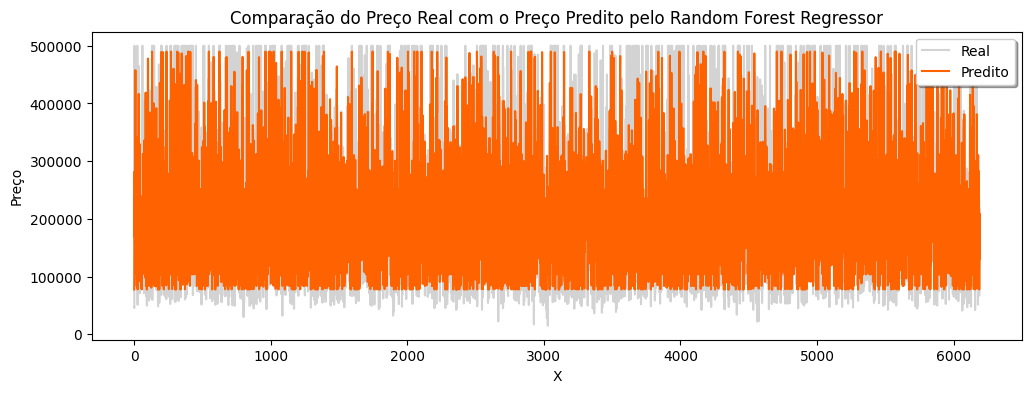

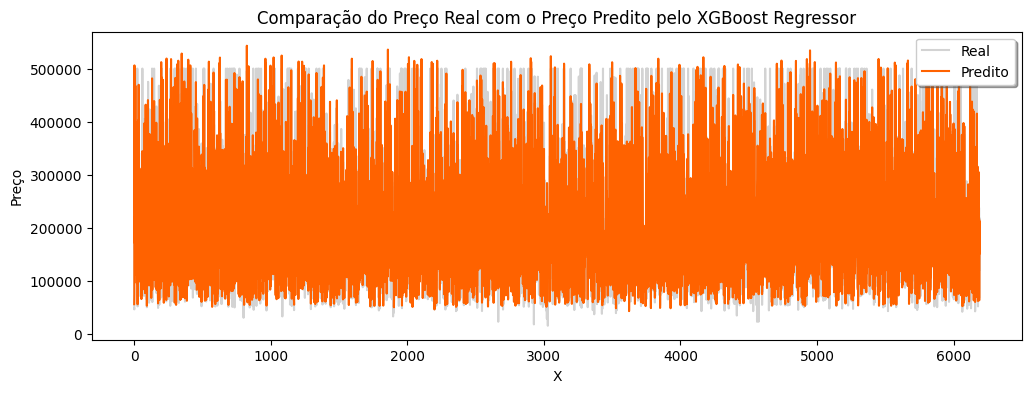

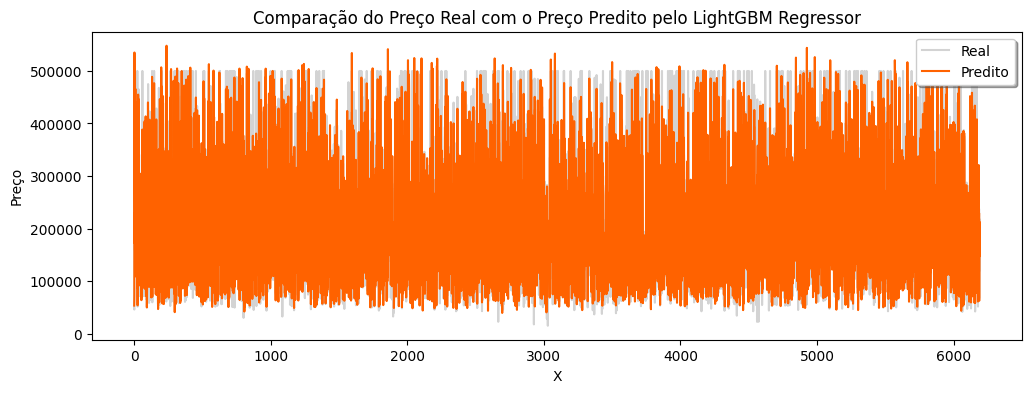

In [47]:
count = 0

for y_pred in [rf_y_pred, xgb_y_pred, gbm_y_pred]:
    x_range = range(len(y_test))
    plt.figure(figsize=(12, 4))
    plt.plot(x_range, y_test, label="Real", color="#D3D3D3")
    plt.plot(x_range, y_pred, label="Predito", color="#FF6200")
    if count == 0:
        plt.title(f"Comparação do Preço Real com o Preço Predito pelo Random Forest Regressor")
    if count == 1:
        plt.title(f"Comparação do Preço Real com o Preço Predito pelo XGBoost Regressor")
    if count == 2:
        plt.title(f"Comparação do Preço Real com o Preço Predito pelo LightGBM Regressor")
    plt.xlabel("X")
    plt.ylabel("Preço")
    plt.legend(loc="upper right", fancybox=True, shadow=True)
    plt.show()
    count += 1

#### Referências utilizadas para desenvolvimento do projeto

0. [KNN Imputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)

1. [Random Forest Regressor](https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

2. [Randomized Search CV](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

3. [XGBoost Regressor](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor)

4. [Grid Search CV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

5. [LightGBM Regressor](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html)

6. [Material da Disciplina de Machine Learning](https://github.com/dhenyfernandes/9DTS)